In [2]:
## PYTHON LIBRARIES
# Importing libraries
import sys
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm, tqdm_notebook
import matplotlib.gridspec
from scipy import stats
import matplotlib.patches as mpatches
# Define some general functions
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import datetime
import statsmodels
import math

from skbio.stats.distance import anosim
from scipy.spatial.distance import squareform, pdist
from skbio import DistanceMatrix

import scikit_posthocs as sp
from scipy import stats

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
## WORKING DIRECTORY
path = "../analysis/plots/"

run_type = "dry"
run_type = "wet"

new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#949494", "Intermittent": "#EA8A86", "RapamycinTrametinib":"#EBC69B", "Trametinib":"#7DF17B"}

In [4]:
# Load dataset and metadata
df = pd.read_csv("../data/plasma_normal.csv", sep = ";")
df.set_index("ID", inplace = True)
metadata = pd.read_csv("../metadata/metadata.csv", sep = "\t")
metadata.set_index("ID", inplace = True)

# Subset according to whose study it is
metadata = metadata[metadata["Treatment"].isin(["Control", "Intermittent", "Trametinib", "RapamycinTrametinib"])]
    
df = df[df.index.isin(metadata.index.to_list())]
mer = pd.merge(df, metadata.loc[:, ["Sex", "Treatment"]], left_index = True, right_index = True)

In [10]:
genes = df.columns
def calc_genes(mer):

    sig_genes = []
    ctrl_RT = []
    inter_RT = []
    tram_RT = []
    inter_tram = []
    ctrl_inter = []
    ctrl_tram = []
    for e in sorted(genes):
        control = mer[mer["Treatment"] == "Control"].fillna(0)[e]
        inter = mer[mer["Treatment"] == "Intermittent"].fillna(0)[e]
        RT = mer[mer["Treatment"] == "RapamycinTrametinib"].fillna(0)[e]
        tram = mer[mer["Treatment"] == "Trametinib"].fillna(0)[e]
        ano = stats.f_oneway(control, inter, RT, tram)
        if ano[1] < 0.05:
            sig_genes.append(e)
            ttestdf = pd.DataFrame({"score":list(control) + list(inter) + list(RT) + list(tram), 
                                    "group":["control"]*len(control) + ["intermittent"]*len(inter) + ["RapaTram"]*len(RT) + ["trametinib"]*len(tram)})
            tte = sp.posthoc_ttest(ttestdf.fillna(0), val_col = "score", group_col = "group")
            comp1 = tte.loc[["RapaTram"], ["control"]]["control"][0]
            if comp1 < 0.05:
                ctrl_RT.append(e)
            comp2 = tte.loc[["RapaTram"], ["intermittent"]]["intermittent"][0]
            if comp2 < 0.05:
                inter_RT.append(e)
            comp3 = tte.loc[["RapaTram"], ["trametinib"]]["trametinib"][0]
            if comp3 < 0.05:
                tram_RT.append(e)
            comp4 = tte.loc[["intermittent"], ["trametinib"]]["trametinib"][0]
            if comp4 < 0.05:
                inter_tram.append(e)
            comp5 = tte.loc[["intermittent"], ["control"]]["control"][0]
            if comp5 < 0.05:
                ctrl_inter.append(e)
            comp6 = tte.loc[["trametinib"], ["control"]]["control"][0]
            if comp6 < 0.05:
                ctrl_tram.append(e)
                
    return(sig_genes, ctrl_RT, inter_RT, tram_RT, inter_tram, ctrl_inter, ctrl_tram)
             

merf = mer[mer["Sex"] == "f"]
fsig_genes, fctrl_RT, finter_RT, ftram_RT, finter_tram, fctrl_inter, fctrl_tram = calc_genes(merf)

merm = mer[mer["Sex"] == "m"]
msig_genes, mctrl_RT, minter_RT, mtram_RT, minter_tram, mctrl_inter, mctrl_tram = calc_genes(merm)

# Get a set of male and female sig_genes
mf_genes = list(set(fsig_genes + msig_genes))

# Subset
subs = mer.loc[:, mf_genes + ["Treatment", "Sex"]]

In [24]:
len(mctrl_RT)

4

In [26]:
import math

def log2fc_lis(mf_genes, subs, T1, T2):
    valf = []
    valm = []
    ge = []
    for gene in mf_genes:
        ge.append(gene)
        f = subs[subs["Sex"] == "f"]
        m = subs[subs["Sex"] == "m"]
        fT1 = f[f["Treatment"] == T1][gene].mean() + 1
        fT2 = f[f["Treatment"] == T2][gene].mean() + 1
        fT1 = math.log2(fT1)
        fT2 = math.log2(fT2)
        valf.append((fT1 - fT2)/fT2)
        mT1 = m[m["Treatment"] == T1][gene].mean() + 1
        mT2 = m[m["Treatment"] == T2][gene].mean() + 1
        mT1 = math.log2(mT1)
        mT2 = math.log2(mT2)
        valm.append((mT1 - mT2)/mT2)
        
    df = pd.DataFrame({"gene":ge, "females":valf, "males":valm, "Treatment":[f"{T1}_{T2}"]*len(valf)}).set_index("gene")
        
    return(df)

In [28]:
df_R_ctrl = log2fc_lis(list(set(fctrl_inter + mctrl_inter)), subs, "Intermittent", "Control")
df_T_ctrl = log2fc_lis(list(set(fctrl_tram + mctrl_tram)), subs, "Trametinib", "Control")
df_RT_ctrl = log2fc_lis(list(set(fctrl_RT + mctrl_RT)), subs, "RapamycinTrametinib", "Control")
df_RT_R = log2fc_lis(list(set(finter_RT + minter_RT)), subs, "RapamycinTrametinib", "Intermittent")
df_RT_T = log2fc_lis(list(set(ftram_RT + mtram_RT)), subs, "RapamycinTrametinib", "Trametinib")
df_R_T = log2fc_lis(list(set(finter_tram + minter_tram)), subs, "Intermittent", "Trametinib")

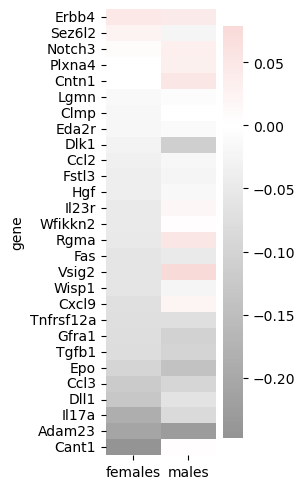

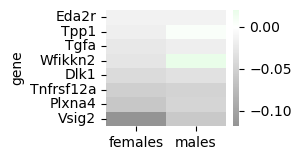

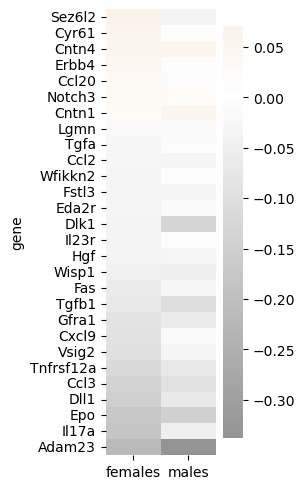

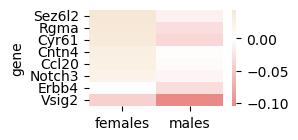

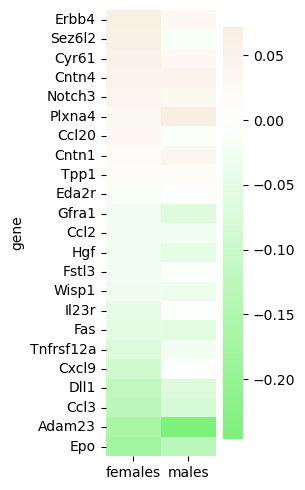

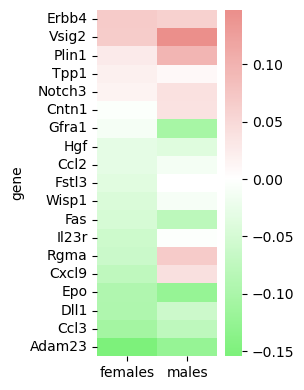

In [64]:
{"Control":"#949494", "Intermittent": "#EA8A86", "RapamycinTrametinib":"#EBC69B", "Trametinib":"#7DF17B"}

import matplotlib.colors

cmapR_ctrl = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#949494","white","#EA8A86"])
cmapT_ctrl = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#949494","white","#7DF17B"])
cmapRT_ctrl = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#949494","white","#EBC69B"])
cmapRT_R = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#EA8A86","white","#EBC69B"])
cmapRT_T = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#7DF17B","white","#EBC69B"])
cmapR_T = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#7DF17B","white","#EA8A86"])


# rapa control
fig, ax = plt.subplots(figsize = (3,5))
cm = sns.heatmap(df_R_ctrl.drop(columns = ["Treatment"]).sort_values("females", ascending = False), 
                 cmap = cmapR_ctrl, center = 0, xticklabels=True, yticklabels=True)

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("{}/LG_sex_rapa_Ctrl_{}.pdf".format(path, new_day))

# tram control
fig, ax = plt.subplots(figsize = (3,1.7))
cm = sns.heatmap(df_T_ctrl.drop(columns = ["Treatment"]).sort_values("females", ascending = False), 
                 cmap = cmapT_ctrl, center = 0, xticklabels=True, yticklabels=True)

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("{}/LG_sex_tram_Ctrl_{}.pdf".format(path, new_day))

# rapatram control
fig, ax = plt.subplots(figsize = (3,5))
cm = sns.heatmap(df_RT_ctrl.drop(columns = ["Treatment"]).sort_values("females", ascending = False), 
                 cmap = cmapRT_ctrl, center = 0, xticklabels=True, yticklabels=True)

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("{}/LG_sex_rapatram_Ctrl_{}.pdf".format(path, new_day))

# rapatram rapa
fig, ax = plt.subplots(figsize = (3,1.5))
cm = sns.heatmap(df_RT_R.drop(columns = ["Treatment"]).sort_values("females", ascending = False), 
                 cmap = cmapRT_R, center = 0, xticklabels=True, yticklabels=True)

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("{}/LG_sex_rapatram_rapa_{}.pdf".format(path, new_day))

# rapatram tram
fig, ax = plt.subplots(figsize = (3,5))
cm = sns.heatmap(df_RT_T.drop(columns = ["Treatment"]).sort_values("females", ascending = False), 
                 cmap = cmapRT_T, center = 0, xticklabels=True, yticklabels=True)

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("{}/LG_sex_rapatram_tram_{}.pdf".format(path, new_day))

# rapa tram
fig, ax = plt.subplots(figsize = (3,4))
cm = sns.heatmap(df_R_T.drop(columns = ["Treatment"]).sort_values("females", ascending = False), 
                 cmap = cmapR_T, center = 0, xticklabels=True, yticklabels=True)

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("{}/LG_sex_rapa_tram_{}.pdf".format(path, new_day))

In [48]:
genes = df.columns

sig_genes = []

sig_control = []
val_control = []
sig_inter = []
val_inter = []
sig_RT = []
val_RT = []
sig_tram = []
val_tram = []

for e in sorted(genes):
    control = mer[mer["Treatment"] == "Control"].fillna(0).sort_values(by=['Sex'])
    inter = mer[mer["Treatment"] == "Intermittent"].fillna(0).sort_values(by=['Sex'])
    RT = mer[mer["Treatment"] == "RapamycinTrametinib"].fillna(0).sort_values(by=['Sex'])
    tram = mer[mer["Treatment"] == "Trametinib"].fillna(0).sort_values(by=['Sex'])
    
    ## Control
    
    se = control["Sex"].value_counts()
    testdf = pd.DataFrame({"score":list(control[e]), "group":["f"]*se[0] + ["m"]*se[1]})
    tte = sp.posthoc_ttest(testdf, val_col = "score", group_col = "group")
    
    comp1 = tte.loc[["f"], ["m"]]["m"][0]
    if comp1 < 0.05:
        sig_genes.append(e)
        sig_control.append(e)
        f = testdf[testdf["group"] == "f"]["score"].mean()
        m = testdf[testdf["group"] == "m"]["score"].mean()
        val_control.append((m - f)/f)
        
    # Inter
    se = inter["Sex"].value_counts()
    testdf = pd.DataFrame({"score":list(inter[e]), "group":["f"]*se[0] + ["m"]*se[1]})
    tte = sp.posthoc_ttest(testdf, val_col = "score", group_col = "group")
    
    comp1 = tte.loc[["f"], ["m"]]["m"][0]
    if comp1 < 0.05:
        sig_genes.append(e)
        sig_inter.append(e)
        f = testdf[testdf["group"] == "f"]["score"].mean()
        m = testdf[testdf["group"] == "m"]["score"].mean()
        val_inter.append((m - f)/f)
        
    # RT
    se = RT["Sex"].value_counts()
    testdf = pd.DataFrame({"score":list(RT[e]), "group":["f"]*se[0] + ["m"]*se[1]})
    tte = sp.posthoc_ttest(testdf, val_col = "score", group_col = "group")
    
    comp1 = tte.loc[["f"], ["m"]]["m"][0]
    if comp1 < 0.05:
        sig_genes.append(e)
        sig_RT.append(e)
        f = testdf[testdf["group"] == "f"]["score"].mean()
        m = testdf[testdf["group"] == "m"]["score"].mean()
        val_RT.append((m - f)/f)
        
    # Tram
    se = tram["Sex"].value_counts()
    testdf = pd.DataFrame({"score":list(tram[e]), "group":["f"]*se[0] + ["m"]*se[1]})
    tte = sp.posthoc_ttest(testdf, val_col = "score", group_col = "group")
    
    comp1 = tte.loc[["f"], ["m"]]["m"][0]
    if comp1 < 0.05:
        sig_genes.append(e)
        sig_tram.append(e)
        f = testdf[testdf["group"] == "f"]["score"].mean()
        m = testdf[testdf["group"] == "m"]["score"].mean()
        val_tram.append((m - f)/f)
        

In [52]:
control = pd.DataFrame({"gene":sig_control, "FC_Ctrl":val_control})
inter = pd.DataFrame({"gene":sig_inter, "FC_Inter":val_inter})
RT = pd.DataFrame({"gene":sig_RT, "FC_RT":val_RT})
tram = pd.DataFrame({"gene":sig_tram, "FC_tram":val_tram})

In [57]:
mer = pd.merge(control, inter, on = "gene", how = "outer")
mer = pd.merge(mer, RT, on = "gene", how = "outer")
mer = pd.merge(mer, tram, on = "gene", how = "outer")
mer = mer.fillna(0)

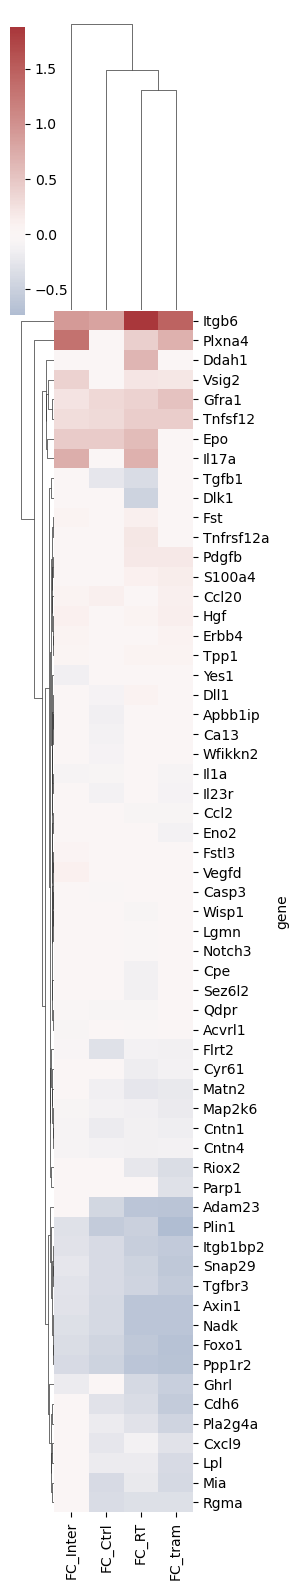

In [82]:
cm = sns.clustermap(mer.set_index("gene"), figsize = (3, 16), cmap = "vlag", center = 0)

matplotlib.rcParams['pdf.fonttype'] = 42
#plt.tight_layout()
    
if run_type != "dry":
    cm.savefig("{}/LG_sexheatmap_{}.pdf".format(path, new_day))
else:
    cm.show()

,FC_Ctrl,FC_Inter,FC_RT,FC_tram
gene,,,,
Adam23,-0.423010,0.000000,-0.635367,-0.643787
Apbb1ip,-0.149539,0.000000,0.000000,0.000000
Axin1,-0.399794,-0.305681,-0.624844,-0.628621
Ca13,-0.121969,0.000000,0.000000,0.000000
Casp3,-0.043574,0.000000,0.000000,0.000000
...,...,...,...,...
Sez6l2,0.000000,0.000000,-0.140147,0.000000
Tnfrsf12a,0.000000,0.000000,0.199006,0.000000
Wisp1,0.000000,0.000000,-0.072702,0.000000
